### Contents:
    01 Importing libraries and data
    02 Data checks
        a merge departments df
        b derive variables/flags
    03 Address PII concerns
    04 More variable derivation
        a explore region variable
    05 Subset customer data
        a crosstab() function
    06 Create exclusion flag
    07 Create flags for order/customer profiling
        a age range
        b shopping time during the day
        c pet flag
        d baby flag
        e frozen flag
        f snacks flag
        e common order day
        f customer income brackets
    08 Export

# Task 4.10 - Part 1

## 01 Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
path = r'/Users/Emily/Documents/CF Data Analysis Program/Immersion 4/Instacart Basket Analysis'

In [3]:
df = pd.read_pickle(os.path.join(path, '02 Data', 'prepared data', 'df_full.pkl'))

In [4]:
# df = pd.read_pickle(os.path.join(path, '02 Data', 'prepared data', 'df_full_30.pkl'))

In [5]:
# df_cust = pd.read_pickle(os.path.join(path, '02 Data', 'prepared data', 'customers_clean.pkl'))

In [6]:
departments = pd.read_csv(os.path.join(path, '02 Data', 'prepared data', 'departments_wrangled.csv'), index_col=0)

## 02 Data checks & Preparation

### Data checks: large df

In [7]:
df.head()

,order_id,user_id,order_number,order_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,...,gender,state,age,date_joined,n_dependants,fam_status,income,price_range,max_order,loyalty_flag
0,2539329,1,1,2,8,NaN,196,1,0,Soda,...,Female,Alabama,31,2/17/2019,3,married,40423,mid,10,new
1,2398795,1,2,3,7,15.0,196,1,1,Soda,...,Female,Alabama,31,2/17/2019,3,married,40423,mid,10,new
2,473747,1,3,3,12,21.0,196,1,1,Soda,...,Female,Alabama,31,2/17/2019,3,married,40423,mid,10,new
3,2254736,1,4,4,7,29.0,196,1,1,Soda,...,Female,Alabama,31,2/17/2019,3,married,40423,mid,10,new
4,431534,1,5,4,15,28.0,196,1,1,Soda,...,Female,Alabama,31,2/17/2019,3,married,40423,mid,10,new


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434212 entries, 0 to 32434211
Data columns (total 26 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   user_id                 int32   
 2   order_number            int8    
 3   order_day_of_week       int8    
 4   order_hour_of_day       int8    
 5   days_since_prior_order  float16 
 6   product_id              int32   
 7   add_to_cart_order       uint8   
 8   reordered               int8    
 9   product_name            object  
 10  aisle_id                int16   
 11  department_id           int8    
 12  prices                  float32 
 13  _merge                  category
 14  first_name              object  
 15  last_name               object  
 16  gender                  object  
 17  state                   object  
 18  age                     int8    
 19  date_joined             object  
 20  n_dependants            int8    
 21  fam_st

In [9]:
df.shape

(32434212, 26)

### Data Checks: departments df

In [10]:
departments.head()

,department
1,frozen
2,other
3,bakery
4,produce
5,alcohol


### a) Merge the two together

In [11]:
%%time
# merge the department names into the big data file
df = df.merge(departments, how='inner', left_on='department_id', right_index=True)

CPU times: user 11 s, sys: 12.6 s, total: 23.6 s
Wall time: 33.5 s


In [12]:
df[['product_id', 'department_id', 'department']].head()

,product_id,department_id,department
0,196,7,beverages
1,196,7,beverages
2,196,7,beverages
3,196,7,beverages
4,196,7,beverages


### b) Add flags from previous tasks & a few new ones

In [13]:
# create a column that lists the average price per product per user
df['avg_prod_price'] = df.groupby('user_id')['prices'].transform('mean')

In [14]:
# create a column that lists the cost of the whole order by taking the sum of the prices in each order
df['ord_cost'] = df.groupby('order_id')['prices'].transform('sum')

In [15]:
# create a column that lists the number of products in each order
df['num_prod_in_order'] = df.groupby('order_id')['add_to_cart_order'].transform('max')

In [16]:
%%time
# create a column that lists the average order cost for each customer
a = df.groupby(['user_id','order_number'])['prices'].sum().to_frame()
b = a.groupby('user_id')['prices'].mean().rename('avg_order_cost')
df = df.merge(b, how='left', on='user_id')

CPU times: user 15.8 s, sys: 16.3 s, total: 32.1 s
Wall time: 40.1 s


In [17]:
%%time
# create a column that lists the median days in between each order
a = df.groupby(['user_id','order_number'])['days_since_prior_order'].min().to_frame()
b = a.groupby('user_id')['days_since_prior_order'].median().rename('median_days_between')
df = df.merge(b, how='left', on='user_id')

CPU times: user 17.2 s, sys: 19 s, total: 36.2 s
Wall time: 49.1 s


In [18]:
# check data types of new columns
df[['avg_prod_price', 'avg_order_cost', 'ord_cost', 'median_days_between', 'num_prod_in_order']].dtypes

avg_prod_price         float32
avg_order_cost         float32
ord_cost               float32
median_days_between    float16
num_prod_in_order        uint8
dtype: object

In [19]:
# down sample data types of new columns
df['avg_prod_price'] = df['avg_prod_price'].astype('float16')
df['avg_order_cost'] = df['avg_order_cost'].astype('float16')
df['ord_cost'] = df['ord_cost'].astype('float16')

In [20]:
# make sure all the new columns look good and make sense (with a random user_id)
df[['order_id', 'user_id', 'prices', 'avg_prod_price',
    'num_prod_in_order', 'ord_cost', 'avg_order_cost', 'max_order',
    'days_since_prior_order', 'median_days_between']].loc[df['user_id'] == 53457].sort_values(by='order_id')

,order_id,user_id,prices,avg_prod_price,num_prod_in_order,ord_cost,avg_order_cost,max_order,days_since_prior_order,median_days_between
18752189,5762,53457,2.0,7.023438,6,27.00000,39.59375,11,30.0,11.0
31025864,5762,53457,2.3,7.023438,6,27.00000,39.59375,11,30.0,11.0
24588146,5762,53457,3.4,7.023438,6,27.00000,39.59375,11,30.0,11.0
18752173,5762,53457,3.2,7.023438,6,27.00000,39.59375,11,30.0,11.0
18752167,5762,53457,6.3,7.023438,6,27.00000,39.59375,11,30.0,11.0
...,...,...,...,...,...,...,...,...,...,...
18752183,3394170,53457,1.2,7.023438,7,50.59375,39.59375,11,30.0,11.0
30054754,3394170,53457,8.1,7.023438,7,50.59375,39.59375,11,30.0,11.0
18752166,3394170,53457,6.3,7.023438,7,50.59375,39.59375,11,30.0,11.0
28767423,3394170,53457,4.6,7.023438,7,50.59375,39.59375,11,30.0,11.0


## Part 1

### 03 Step 2 - Address PII concerns

There's no reason to have the customers' names connected with this data.
Their demographics and a unique id will be enough to glean insights.
Might as well drop department_id, merge, aisle_id at the same time to save RAM.

In [21]:
df2 = df.drop(columns=['first_name', 'last_name', 'department_id', '_merge', 'aisle_id']) 

### 04 Step 3 - flag regions

In [22]:
# create series for each region with all appropriate states
northeast = ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 
             'Connecticut', 'New York', 'Pennsylvania', 'New Jersey']
midwest = ['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio',
          'North Dakota', 'South Dakota', 'Nebraska', 'Kansas',
          'Minnesota', 'Iowa', 'Missouri']
south = ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia',
         'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee',
         'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']
west = ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona',
        'New Mexico', 'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii']

In [23]:
# create a new region column identifying 
df2.loc[df2['state'].isin(northeast), 'region'] = 'northeast'

In [24]:
df2.loc[df2['state'].isin(midwest), 'region'] = 'midwest'

In [25]:
df2.loc[df2['state'].isin(south), 'region'] = 'south'

In [26]:
df2.loc[df2['state'].isin(west), 'region'] = 'west'

In [27]:
# make sure all records were allocated to a region
df2['region'].value_counts(dropna=False)

south        10801610
west          8300445
midwest       7603810
northeast     5728347
Name: region, dtype: int64

#### a) explore new region variable

In [28]:
# there are more users in the south
df2[['region', 'user_id']].groupby('region').agg({'user_id': pd.Series.nunique,}).sort_values(by='user_id',
                                                                                              ascending=False)

,user_id
region,
south,68737
west,52565
midwest,48519
northeast,36388


In [29]:
# there are more states in the south
# and each state has essentially the same number of people
# this was seen in the consistency checks for the customer data set
df2[['region', 'state']].groupby('region').agg({'state': pd.Series.nunique,}).sort_values(by='state',
                                                                                          ascending=False)

,state
region,
south,17
west,13
midwest,12
northeast,9


In [30]:
# there has been more money spent in the south
df2[['prices', 'region']].groupby(['region']).agg('sum').sort_values(by='prices', ascending=False)

,prices
region,
south,84234000.0
west,64693172.0
midwest,59277424.0
northeast,44602964.0


In [31]:
# there have been more products purchased in the south
df2[['region', 'product_id']].groupby(['region']).agg('count').sort_values(by='product_id', ascending=False)

,product_id
region,
south,10801610
west,8300445
midwest,7603810
northeast,5728347


In [32]:
# create a new df that summarizes data by region
# rename the columns so that it nothing gets confused
df_region = df2[['prices', 'region', 'user_id', 'order_id']].groupby(['region']).agg(
    {'prices':'sum', 'user_id': pd.Series.nunique, 'order_id': pd.Series.nunique})
df_region = df_region.rename(columns={'prices':'prices_sum', 'user_id': 'user_count', 'order_id': 'order_count'})
df_region

,prices_sum,user_count,order_count
region,,,
midwest,59277424.0,48519,754324
northeast,44602964.0,36388,567185
south,84234000.0,68737,1071631
west,64693172.0,52565,821721


In [33]:
# create calculated columns based on the aggregated data
df_region['price_per_order'] = df_region['prices_sum']/df_region['order_count']
df_region['price_per_user'] = df_region['prices_sum']/df_region['user_count']
df_region['order_per_user'] = df_region['order_count']/df_region['user_count']

In [34]:
df_region.sort_values(by='price_per_user', ascending=False)

,prices_sum,user_count,order_count,price_per_order,price_per_user,order_per_user
region,,,,,,
west,64693172.0,52565,821721,78.728878,1230.727138,15.632474
northeast,44602964.0,36388,567185,78.639181,1225.760251,15.587144
south,84234000.0,68737,1071631,78.603549,1225.453540,15.590308
midwest,59277424.0,48519,754324,78.583505,1221.736309,15.546982


### 05 Subset customer data

In [35]:
# create a df that just lists customers
customers = df2.drop_duplicates(subset=['user_id'])
customers.shape

(206209, 28)

#### a) crosstab function

In [36]:
# use crosstab to see if there are more loyal customers in different regions
cross = pd.crosstab(customers['region'], customers['loyalty_flag'], dropna=False).sort_index()
cross

loyalty_flag,loyal,new,regular
region,,,
midwest,3991,26333,18195
northeast,3027,19869,13492
south,5637,37491,25609
west,4362,28635,19568


In [37]:
# Percentage of loyal customers in the regions
print('midwest: ', round(cross.iloc[0,0]/cross.iloc[0].sum()*100, 2), '%')
print('northeast: ', round(cross.iloc[1,0]/cross.iloc[1].sum()*100, 2), '%')
print('south: ', round(cross.iloc[2,0]/cross.iloc[2].sum()*100, 2), '%')
print('west: ', round(cross.iloc[3,0]/cross.iloc[3].sum()*100, 2), '%')

midwest:  8.23 %
northeast:  8.32 %
south:  8.2 %
west:  8.3 %


The south has more customers, more orders, and more products purchased, but not a higher percentage of loyal customers. Loyal is defined by more than 40 orders in the year sampled.

### 06 Step 4 - Create an exclusion flag for low-activity customers

In [38]:
# to keep size down, I'm using a binary for this exclusion flag instead of a string
df2.loc[df2['max_order'] < 5, 'exclusion'] = 1

In [39]:
df2.loc[df2['max_order'] >= 5, 'exclusion'] = 0

In [40]:
# check to see that all records were allocated
df2['exclusion'].value_counts(dropna=False)

0.0    30992664
1.0     1441548
Name: exclusion, dtype: int64

In [41]:
# adjust data type for efficiency
df2['exclusion'] = df2['exclusion'].astype('int8')

### 07 Step 5 - Create profiling variables to find insights

In [42]:
# create a df that just lists orders (and only the necessary columns)
orders = df2.drop_duplicates(subset='order_id')
orders.shape

(3214861, 29)

In [43]:
# create a df that just lists customers
customers = df2.drop_duplicates(subset=['user_id'])
customers.shape

(206209, 29)

#### a) Age ranges for customer

In [44]:
# Divide up the ages of customers into 4 ranges: under 35, between 35 and 50, between 50 and 65, and 65+
# and create new column with the info
df2.loc[df2['age'] < 35, 'age_range'] = 1

In [45]:
df2.loc[(df2['age'] >= 35) & (df2['age'] < 50), 'age_range'] = 2

In [46]:
df2.loc[(df2['age'] >= 50) & (df2['age'] < 65), 'age_range'] = 3

In [47]:
df2.loc[df2['age'] >= 65, 'age_range'] = 4

In [48]:
df2['age_range'] = df2['age_range'].astype('int8')

#### b) Shopping time for order

<AxesSubplot:>

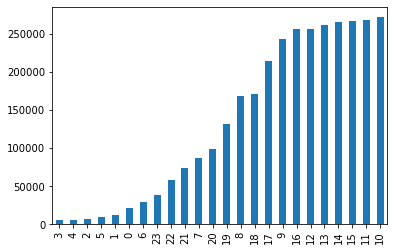

In [49]:
orders['order_hour_of_day'].value_counts().sort_values().plot.bar()

In [50]:
# create a list of value for a order busyness flag. I divided the 24 hours into 3 levels of busyness
x = []
for value in df2['order_hour_of_day']:
    if value <= 6 or value >= 23:
        x.append(3) # 3 for least busiest
    elif value >= 9 and value < 17:
        x.append(1) # 1 for most busy
    elif value < 9 and value > 6:
        x.append(2) # 2 for medium busy
    elif value >=17 and value < 23:
        x.append(2) # 2 for medium busy
    else:
        x.append(np.nan)

In [51]:
# set the new column and set the data type
df2['hour_range'] = x
df2['hour_range'] = df2['hour_range'].astype('int8')

#### c) Pet flag for customer

In [52]:
# first, identify all the products purchased from the pet department
df2['pet_stuff'] = [1 if x == 'pets' else 0 for x in df2['department']]

In [53]:
# then, apply it across the whole customer's orders
df2['pet_stuff'] = df2.groupby(['user_id'])['pet_stuff'].transform('max')

In [54]:
# and down sample the data type
df2['pet_stuff'] = df2['pet_stuff'].astype('int8')

#### d) Baby flag for customer

In [55]:
# first, identify all the products purchased from the pet department
df2['baby_stuff'] = [1 if x == 'babies' else 0 for x in df2['department']]

In [56]:
# then, apply it across the whole customer's orders
df2['baby_stuff'] = df2.groupby(['user_id'])['baby_stuff'].transform('max')

In [57]:
# and down sample the data type
df2['baby_stuff'] = df2['baby_stuff'].astype('int8')

#### e) Frozen flag for order

In [58]:
# first, identify all the products purchased from the pet department
df2['frozen_stuff'] = [1 if x == 'frozen' else 0 for x in df2['department']]

In [59]:
# then, apply it across the whole customer's orders
df2['frozen_stuff'] = df2.groupby(['order_id'])['frozen_stuff'].transform('max')

In [60]:
# and down sample the data type
df2['frozen_stuff'] = df2['frozen_stuff'].astype('int8')

#### f) Snacks flag for order

In [61]:
# first, identify all the products purchased from the pet department
df2['snacks'] = [1 if x == 'snacks' else 0 for x in df2['department']]

In [62]:
# then, apply it just across the individual order
df2['snacks'] = df2.groupby(['order_id'])['snacks'].transform('max')

In [63]:
# and down sample the data type
df2['snacks'] = df2['snacks'].astype('int8')

#### f) Order_day_of_week mode for customer

In [64]:
%%time
# create a column that list the most common day of the week for ordering
a = (orders.groupby('user_id')['order_day_of_week']
     .agg(lambda x: pd.Series.mode(x)[0]).rename('common_order_day').to_frame())
df2 = df2.merge(a, how='left', left_on='user_id', right_index=True)

CPU times: user 35.9 s, sys: 8.97 s, total: 44.8 s
Wall time: 51 s


#### g) Income brackets for customer

<AxesSubplot:ylabel='Frequency'>

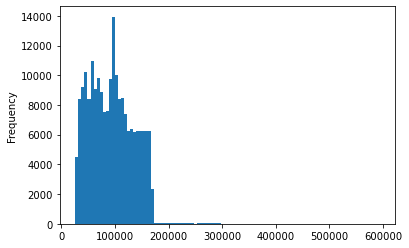

In [65]:
# vizualize the distribution of income for all customers
customers['income'].plot.hist(bins=100)

In [66]:
# find the descriptive stats for the variable
customers['income'].describe()

count    206209.000000
mean      94632.852548
std       42473.786988
min       25903.000000
25%       59874.000000
50%       93547.000000
75%      124244.000000
max      593901.000000
Name: income, dtype: float64

In [67]:
# create income groupings based on quartiles
x = []
for value in df2['income']:
    if value < 60000:
        x.append(1) # income group #1 
    elif value >= 60000 and value < 94000:
        x.append(2) # income group #2
    elif value >= 94000 and value < 124000:
        x.append(3) # income group #3
    elif value >= 124000:
        x.append(4) # income group #4
    else:
        x.append(np.nan)

In [68]:
df2['income_range'] = x

In [69]:
df2['income_range'] = df2['income_range'].astype('int8')

## 08 Export to set up for next notebook

In [70]:
# whoa, that's a lot of columns
df2.shape

(32434212, 37)

In [71]:
%%time
df2.to_pickle(os.path.join(path, '02 Data', 'prepared data', 'df_410.pkl'))

CPU times: user 12.2 s, sys: 13.8 s, total: 26 s
Wall time: 38.2 s


In [72]:
df_region.to_csv(os.path.join(path, '02 Data', 'prepared data', 'df_410_region.csv'))